<a href="https://colab.research.google.com/github/reshalfahsi/contrastive-ssl-pathology/blob/master/Self_Supervised_Contrastive_Learning_for_Colon_Pathology_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Self-Supervised Contrastive Learning for Colon Pathology Classification**



## **Important Libraries**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 378.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 168.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 188.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 254.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 348.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 240.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 279.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 173.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 329.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 279.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 264.8 MB/s eta 0:00:00
  Preparing metadata (setup.py

In [ ]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.classification import Accuracy

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import cv2
import random
import math

from medmnist import PathMNIST
from medmnist.dataset import MedMNIST

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'

## **Dataset**

In [ ]:
NUM_CLASSES = 9

In [ ]:
image_transform = Compose(
    [
        ToTensor(),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
augmentation_transform = Compose(
    [
        transforms.RandomApply(
            torch.nn.ModuleList(
                [
                    transforms.RandomAffine(
                        degrees=180.0,
                        translate=(0.45, 0.45),
                        scale=(0.6, 1.35)
                    ),
                ]
            ),
            p=0.64,
        ),
        transforms.RandomVerticalFlip(p=0.64),
        transforms.RandomHorizontalFlip(p=0.64),
        transforms.RandomApply(
            torch.nn.ModuleList(
                [
                    transforms.ColorJitter(
                        brightness=0.6,
                        contrast=0.3,
                        saturation=0.3,
                        hue=0.3,
                    ),
                ]
            ),
            p=0.64,
        ),
        ToTensor(),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
class MedMNIST2DInference(MedMNIST):

    def __len__(self):
        return 1

    def set_inference_index(self, index):
        self.inference_index = index

    @property
    def ground_truth_image(self):
        return self.imgs[self.inference_index]

    @property
    def ground_truth_class(self):
        return self.labels[self.inference_index].astype(int)

    def __getitem__(self, index):
        '''
        return: (without transform/target_transofrm)
            img: PIL.Image
            target: np.array of `L` (L=1 for single-label)
        '''
        index = self.inference_index
        img = self.imgs[index]
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img


class PathMNISTInference(MedMNIST2DInference):
    flag = "pathmnist"

In [ ]:
class MedMNIST2DSSL(MedMNIST):

    def set_augmentation(self, aug_transform):
        self.aug_transform = aug_transform

    def __getitem__(self, index):
        '''
        return: (without transform/target_transofrm)
            img: PIL.Image
            target: np.array of `L` (L=1 for single-label)
        '''
        img, target = self.imgs[index], self.labels[index].astype(int)
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert('RGB')

        try:
            img_aug = self.aug_transform(img)
        except:
            raise NotImplementedError("Augmentation transform is not set!")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img_aug, img, target


class PathMNISTSSL(MedMNIST2DSSL):
    flag = "pathmnist"

In [ ]:
TrainDataset = PathMNIST(
    split="train",
    transform=image_transform,
    download=True,
)
TestDataset = PathMNIST(
    split="test",
    transform=image_transform,
    download=True,
)
ValDataset = PathMNIST(
    split="val",
    transform=image_transform,
    download=True,
)
SSLTrainDataset = PathMNISTSSL(
    split="train",
    transform=image_transform,
    download=True,
)
SSLTrainDataset.set_augmentation(augmentation_transform)

100%|██████████| 205615438/205615438 [03:21<00:00, 1021629.00it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(TrainDataset)
print("\n\n\n===========================================================\n\n\n")
print(TestDataset)
print("\n\n\n===========================================================\n\n\n")
print(ValDataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


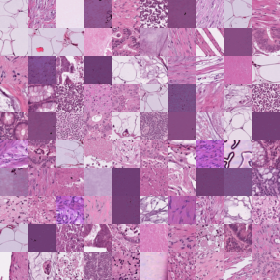

In [ ]:
TrainDataset.montage(length=10)

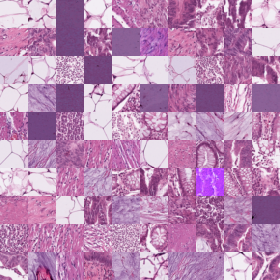

In [ ]:
TestDataset.montage(length=10)

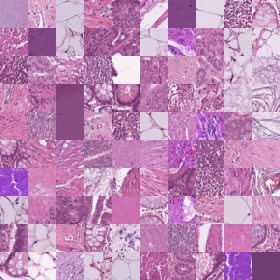

In [ ]:
ValDataset.montage(length=10)

## **Configuration and Utilities**

In [ ]:
MODEL = dict()
MODEL_NAME = dict()
ACC_HISTORY = dict()
LOSS_HISTORY = dict()


CLASS_NAME = {
    "0": "adipose",
    "1": "background",
    "2": "debris",
    "3": "lymphocytes",
    "4": "mucus",
    "5": "smooth muscle",
    "6": "normal colon mucosa",
    "7": "cancer-associated stroma",
    "8": "colorectal adenocarcinoma epithelium",
}

In [ ]:
MAX_EPOCH = 16
BATCH_SIZE = 96
LR = 1e-3
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

Random seed: 369330820


In [ ]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

## **Tensorboard**

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

## **Baseline Model**

### **Model Utilities**

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        del self.backbone.conv1, self.backbone.bn1, self.backbone.relu
        del self.backbone.maxpool, self.backbone.layer2, self.backbone.fc
        self.classifier = nn.Sequential(
            nn.Linear(512, NUM_CLASSES),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.backbone.layer1(x)
        x = self.conv2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class BaselineWrapper(L.LightningModule):
    def __init__(self, arch, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=9)

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.val_accuracy.update(y_hat.softmax(1), y)
        acc = self.val_accuracy.compute().data.cpu()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc", self.test_accuracy.compute(), prog_bar=True, logger=True
        )

    def on_train_end(self):

        # Loss
        loss_img_file = "/content/loss_plot_baseline.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["baseline"] = self.val_loss

        # Accuracy
        acc_img_file = "/content/acc_plot_baseline.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["baseline"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.125),
                    int(self.max_epoch * 0.375),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

### **Training**

INFO: Global seed set to 369330820
INFO:lightning.fabric.utilities.seed:Global seed set to 369330820
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 282MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exi

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


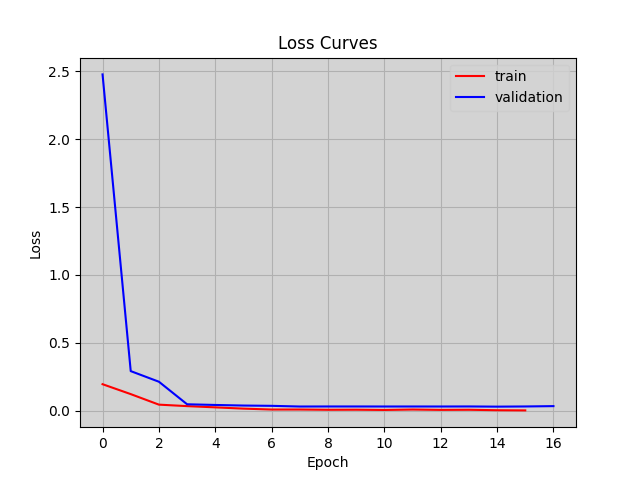

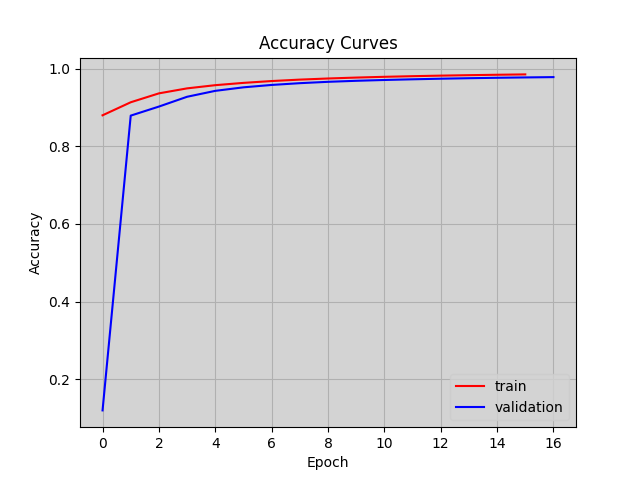

<Figure size 640x480 with 0 Axes>

In [ ]:
seed_everything(SEED, workers=True)


MODEL_NAME['baseline'] = "BaselineModel"
MODEL["baseline"] = BaselineModel()
MODEL["baseline"] = BaselineWrapper(MODEL["baseline"], BATCH_SIZE, LR, MAX_EPOCH)


tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=5, verbose=False, mode="max"
)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(MODEL["baseline"])

### **Testing**

In [ ]:
trainer.test(ckpt_path="best")

INFO: Restoring states from the checkpoint path at /content/epoch=15-step=15008.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=15-step=15008.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=15-step=15008.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=15-step=15008.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9188592433929443     │
│         test_loss         │    0.3668789863586426     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3668789863586426, 'test_acc': 0.9188592433929443}]

In [ ]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['baseline']}_best.ckpt")
)

### **Inference**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoi

Predicting: 0it [00:00, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoi

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/BaselineModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/BaselineModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

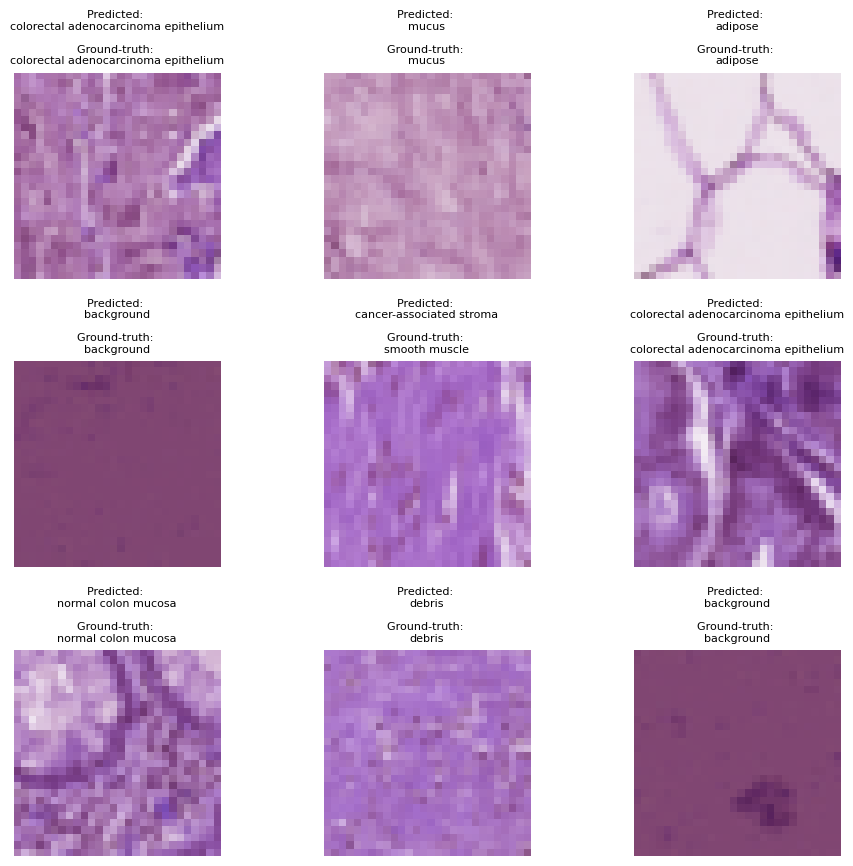

In [ ]:
MODEL['baseline'].arch = trainer.strategy._lightning_module.arch

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

for index in range(0, NUM_CLASSES):
    sample_idx = random.randint(0, len(TestDataset) - 1)
    InferenceDataset = PathMNISTInference(
        split="test",
        transform=image_transform,
        download=True,
    )
    InferenceDataset.set_inference_index(sample_idx)
    gt_class = InferenceDataset.ground_truth_class

    trainer = Trainer()
    prediction = trainer.predict(
        model=MODEL['baseline'],
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['baseline']}_best.ckpt"),
    )[0]

    prediction.softmax(1)
    predicted_class = CLASS_NAME[str(torch.argmax(prediction).data.cpu().numpy())]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{CLASS_NAME[str(gt_class[0])]}"

    ax = fig.add_subplot(3, 3, index + 1)

    img = InferenceDataset.ground_truth_image.copy()
    img[:, :, (0, 1, 2)] = img[:, :, (2, 1, 0)]
    ax.imshow(img.astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

## **Self-Supervised Learning Model**

### **Model Utilities**

In [ ]:
class SSLModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        del self.backbone.conv1, self.backbone.bn1, self.backbone.relu
        del self.backbone.maxpool, self.backbone.layer2, self.backbone.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.backbone.layer1(x)
        x = self.conv2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [ ]:
class SSLWrapper(L.LightningModule):
    def __init__(self, arch, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self._device = "gpu" if torch.cuda.is_available() else "cpu"

        self.train_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=9)

        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, NUM_CLASSES),
        )

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x, aug=False):
        x = self.arch(x)
        embedding = self.projection(x)
        if aug:
            return embedding
        classify = self.classifier(x)
        return embedding, classify

    def loss_function(self, emb1, emb2, temperature=0.5):
        proj1 = F.normalize(emb1, 2, 1)
        proj2 = F.normalize(emb2, 2, 1)
        proj2 = torch.transpose(proj2, 0, 1)

        sim = torch.matmul(proj1, proj2) / temperature
        label = torch.arange(proj1.shape[0]).to(self._device)

        loss1 = F.cross_entropy(sim, label)
        loss2 = F.cross_entropy(torch.transpose(sim, 0, 1), label)

        return (loss1 + loss2) / 2.

    def training_step(self, batch, batch_nb):
        x_, x, y = batch
        emb1, y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()[0]
        opt.zero_grad()
        self.manual_backward(loss, retain_graph=True)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        emb2 = self(x_, aug=True)
        loss = self.loss_function(emb1, emb2)

        opt = self.optimizers()[1]
        opt.zero_grad()
        self.manual_backward(loss, retain_graph=True)
        opt.step()

    def on_train_epoch_end(self):
        for sch in self.lr_schedulers():
            sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        _, y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.val_accuracy.update(y_hat.softmax(1), y)
        acc = self.val_accuracy.compute().data.cpu()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        _, y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", self.test_accuracy.compute(), prog_bar=True, logger=True)

    def on_train_end(self):
        # Loss
        loss_img_file = "/content/loss_plot_ssl.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["ssl"] = self.val_loss

        # Accuracy
        acc_img_file = "/content/acc_plot_ssl.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["ssl"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=SSLTrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        params_classifier = list(self.arch.parameters()) + list(
            self.classifier.parameters()
        )
        optimizer_classifier = optim.Adam(
            params_classifier,
            lr=self.lr,
        )
        params_projection = list(self.arch.parameters()) + list(
            self.projection.parameters()
        )
        optimizer_projection = optim.Adam(
            params_projection,
            lr=self.lr,
        )

        lr_scheduler_classifier = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer_classifier,
                milestones=[
                    int(self.max_epoch * 0.125),
                    int(self.max_epoch * 0.375),
                ],
                gamma=0.1,
            ),
            "name": "lr_scheduler_classifier",
        }

        lr_scheduler_projection = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer_projection,
                milestones=[
                    int(self.max_epoch * 0.125),
                    int(self.max_epoch * 0.375),
                ],
                gamma=0.1,
            ),
            "name": "lr_scheduler_projection",
        }

        return [
            optimizer_classifier,
            optimizer_projection,
        ], [
            lr_scheduler_classifier,
            lr_scheduler_projection,
        ]

### **Training**

INFO: Global seed set to 369330820
INFO:lightning.fabric.utilities.seed:Global seed set to 369330820
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | arch           | SSLModel           | 10.7 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_a

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


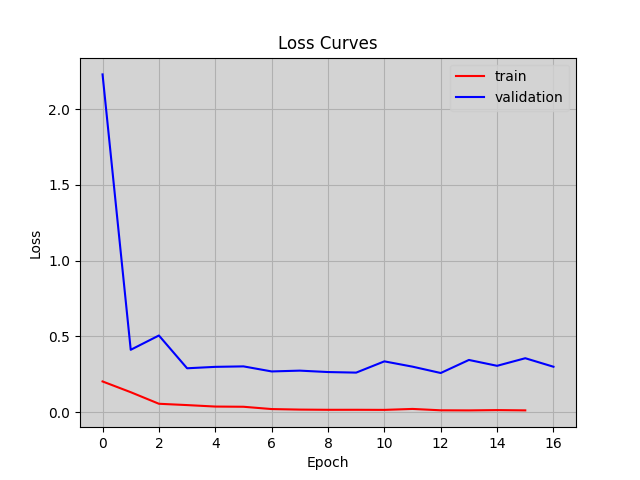

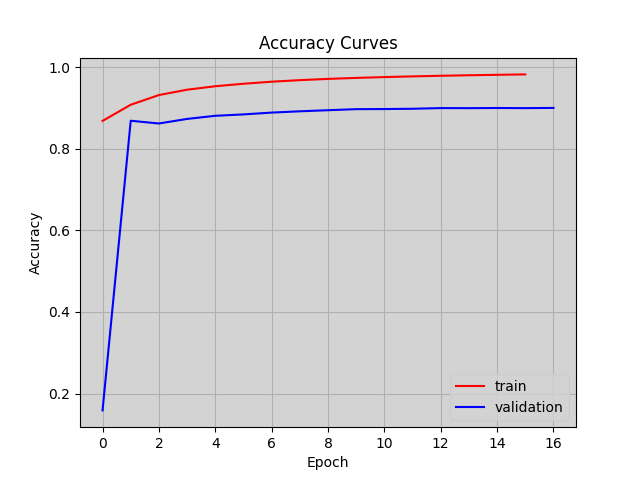

<Figure size 640x480 with 0 Axes>

In [ ]:
seed_everything(SEED, workers=True)


MODEL_NAME['ssl'] = "SSLModel"
MODEL["ssl"] = SSLModel()
MODEL["ssl"] = SSLWrapper(MODEL["ssl"], BATCH_SIZE, LR, MAX_EPOCH)


tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=5, verbose=False, mode="max"
)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(MODEL["ssl"])

### **Testing**

In [ ]:
trainer.test(ckpt_path="best")

INFO: Restoring states from the checkpoint path at /content/epoch=15-step=30016.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=15-step=30016.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=15-step=30016.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=15-step=30016.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.863242506980896     │
│         test_loss         │    0.48048627376556396    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.48048627376556396, 'test_acc': 0.863242506980896}]

In [ ]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['ssl']}_best.ckpt")
)

### **Inference**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/SSLModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/SSLModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

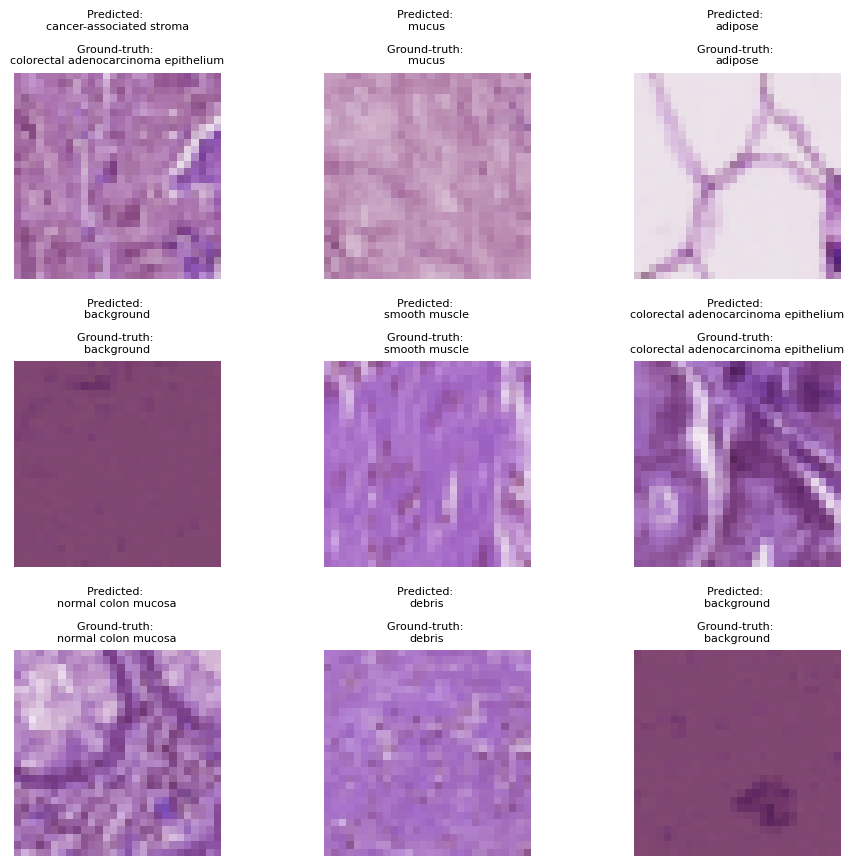

In [ ]:
MODEL['ssl'].arch = trainer.strategy._lightning_module.arch
MODEL['ssl'].classifier = trainer.strategy._lightning_module.classifier
MODEL['ssl'].projection = trainer.strategy._lightning_module.projection


plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

for index in range(0, NUM_CLASSES):
    sample_idx = random.randint(0, len(TestDataset) - 1)
    InferenceDataset = PathMNISTInference(
        split="test",
        transform=image_transform,
        download=True,
    )
    InferenceDataset.set_inference_index(sample_idx)
    gt_class = InferenceDataset.ground_truth_class

    trainer = Trainer()
    _, prediction = trainer.predict(
        model=MODEL['ssl'],
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['ssl']}_best.ckpt"),
    )[0]

    prediction.softmax(1)
    predicted_class = CLASS_NAME[str(torch.argmax(prediction).data.cpu().numpy())]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{CLASS_NAME[str(gt_class[0])]}"

    ax = fig.add_subplot(3, 3, index + 1)

    img = InferenceDataset.ground_truth_image.copy()
    img[:, :, (0, 1, 2)] = img[:, :, (2, 1, 0)]
    ax.imshow(img.astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

## **Supervised Finetuning of Pretrained SSL Model**

### **Model Utilities**

In [ ]:
class FinetunedModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.ssl_pretrained = MODEL["ssl"].arch
        self.classifier = nn.Sequential(
            nn.Linear(512, NUM_CLASSES),
        )

    def forward(self, x):
        x = self.ssl_pretrained(x)
        x = self.classifier(x)
        return x

In [ ]:
class FinetunedWrapper(L.LightningModule):
    def __init__(self, arch, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=9)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=9)

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.val_accuracy.update(y_hat.softmax(1), y)
        acc = self.val_accuracy.compute().data.cpu()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc", self.test_accuracy.compute(), prog_bar=True, logger=True
        )

    def on_train_end(self):

        # Loss
        loss_img_file = "/content/loss_plot_finetuned.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["finetuned"] = self.val_loss

        # Accuracy
        acc_img_file = "/content/acc_plot_finetuned.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["finetuned"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.125),
                    int(self.max_epoch * 0.375),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

### **Training**

INFO: Global seed set to 369330820
INFO:lightning.fabric.utilities.seed:Global seed set to 369330820
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | arch           | FinetunedModel     | 10.7 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_a

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


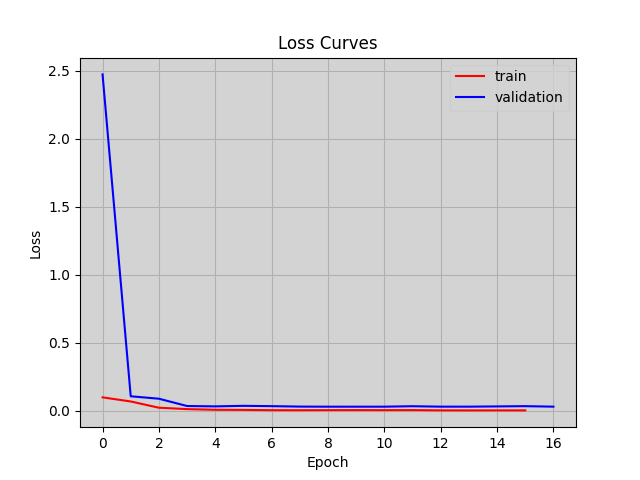

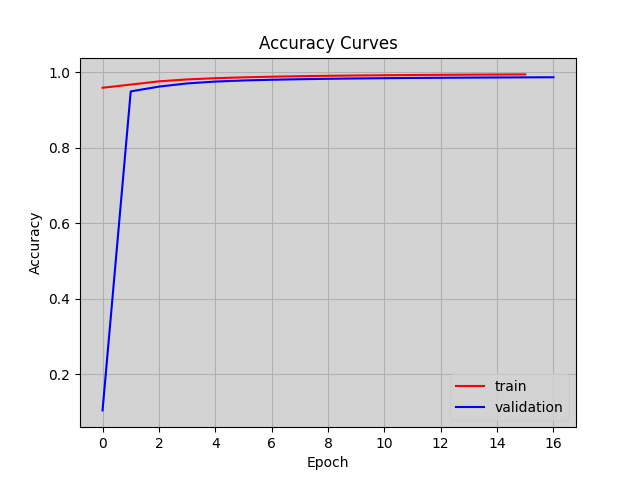

<Figure size 640x480 with 0 Axes>

In [ ]:
seed_everything(SEED, workers=True)


MODEL_NAME['finetuned'] = "FinetunedModel"
MODEL["finetuned"] = FinetunedModel()
MODEL["finetuned"] = FinetunedWrapper(MODEL["finetuned"], BATCH_SIZE, LR, MAX_EPOCH)


tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=5, verbose=False, mode="max"
)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(MODEL["finetuned"])

### **Testing**

In [ ]:
trainer.test(ckpt_path="best")

INFO: Restoring states from the checkpoint path at /content/epoch=15-step=15008.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=15-step=15008.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=15-step=15008.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=15-step=15008.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9105421304702759     │
│         test_loss         │    0.4375055432319641     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4375055432319641, 'test_acc': 0.9105421304702759}]

In [ ]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['finetuned']}_best.ckpt")
)

### **Inference**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/FinetunedModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/FinetunedModel_best.ckpt


Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

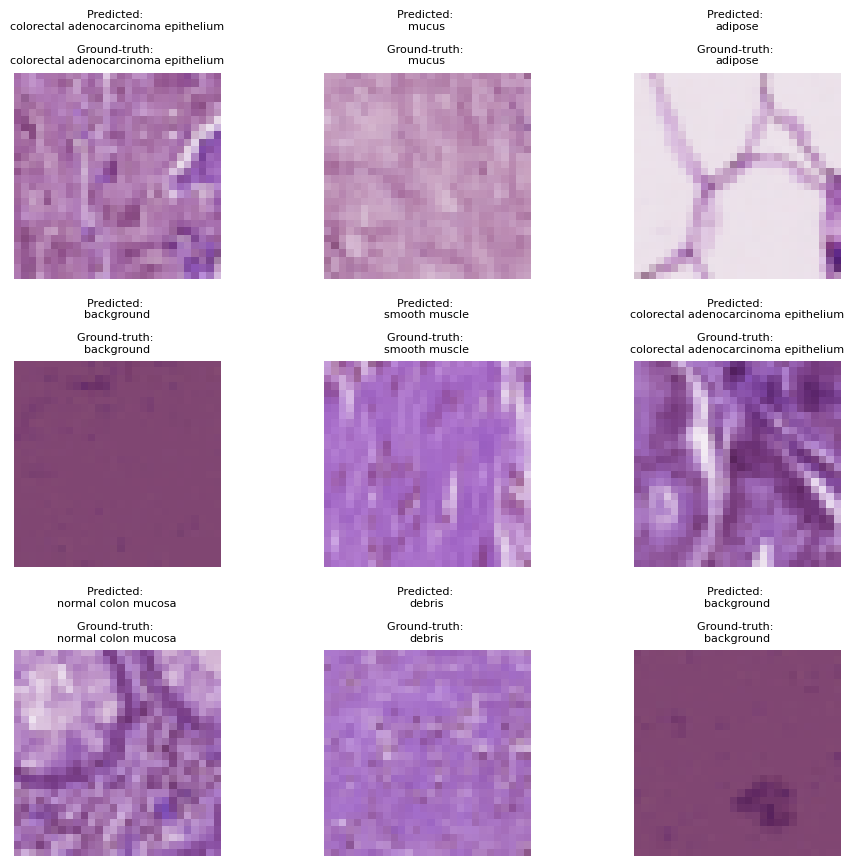

In [ ]:
MODEL['finetuned'].arch = trainer.strategy._lightning_module.arch

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

for index in range(0, NUM_CLASSES):
    sample_idx = random.randint(0, len(TestDataset) - 1)
    InferenceDataset = PathMNISTInference(
        split="test",
        transform=image_transform,
        download=True,
    )
    InferenceDataset.set_inference_index(sample_idx)
    gt_class = InferenceDataset.ground_truth_class

    trainer = Trainer()
    prediction = trainer.predict(
        model=MODEL['finetuned'],
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME['finetuned']}_best.ckpt"),
    )[0]

    prediction.softmax(1)
    predicted_class = CLASS_NAME[str(torch.argmax(prediction).data.cpu().numpy())]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{CLASS_NAME[str(gt_class[0])]}"

    ax = fig.add_subplot(3, 3, index + 1)

    img = InferenceDataset.ground_truth_image.copy()
    img[:, :, (0, 1, 2)] = img[:, :, (2, 1, 0)]
    ax.imshow(img.astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

## **Comparison**

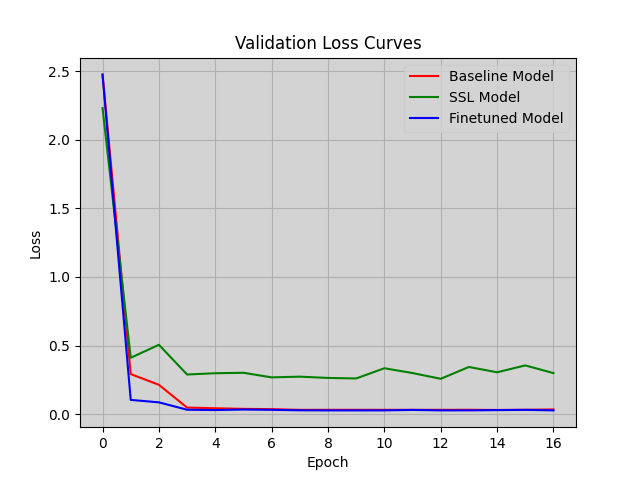

<Figure size 640x480 with 0 Axes>

In [ ]:
loss_img_file = "/content/loss_plot_comparison.png"
plt.plot(LOSS_HISTORY["baseline"], color="r", label="Baseline Model")
plt.plot(LOSS_HISTORY["ssl"], color="g", label="SSL Model")
plt.plot(LOSS_HISTORY["finetuned"], color="b", label="Finetuned Model")
plt.title("Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(loss_img_file)
plt.clf()
img = cv2.imread(loss_img_file)
cv2_imshow(img)

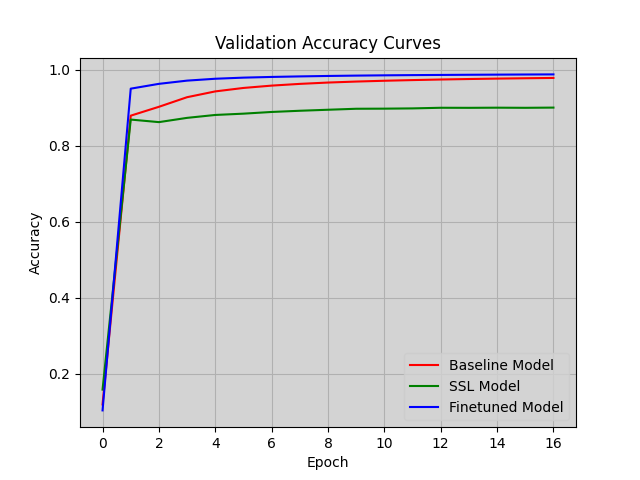

<Figure size 640x480 with 0 Axes>

In [ ]:
acc_img_file = "/content/acc_plot_comparison.png"
plt.plot(ACC_HISTORY["baseline"], color="r", label="Baseline Model")
plt.plot(ACC_HISTORY["ssl"], color="g", label="SSL Model")
plt.plot(ACC_HISTORY["finetuned"], color="b", label="Finetuned Model")
plt.title("Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig(acc_img_file)
plt.clf()
img = cv2.imread(acc_img_file)
cv2_imshow(img)